<a href="https://colab.research.google.com/github/Eugene31415/Data_science/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.python.keras.preprocessing import image as kp_image

import PIL
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from skimage.io import imread, imshow
from skimage.transform import resize

import time
import functools 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
img_size = 300
style_path_1 = '/content/gdrive/MyDrive/images/style88.jpg'
style_path_2 = '/content/gdrive/MyDrive/images/style17.jpg'
content_path = '/content/gdrive/MyDrive/images/content2.jpg'

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = PIL.Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), PIL.Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68] and with channels BGR.

In [ ]:
def load_and_process_img(path):
    img = load_img(path)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(img):
    x = img.copy() # shallow copy works there
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ('Input should be 3 dimensions')

    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x = x[:,:,::-1]

    x = np.clip(x,0,255).astype('uint8')
    return x

In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def get_model():
    model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    model.trainable = False

    style_outputs = [model.get_layer(name).output for name in style_layers]
    content_outputs = [model.get_layer(name).output for name in style_layers]

    model.outputs = style_outputs + content_outputs

    return models.Model(model.input, model.outputs)

In [ ]:
def get_content_loss(input, target):
    return tf.reduce_mean(tf.square(input - target))

In [ ]:
a = tf.constant([[1,2,3],[4,5,6]])
b = tf.reshape(a,[-1,3])
print(b.numpy())
tf.shape(b)

[[1 2 3]
 [4 5 6]]


<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2, 3], dtype=int32)>

In [ ]:
def gram_matrix(tensor):
    assert len(tensor.shape) == 3, 'Gramm_matrix is fed with not 3 dimensioned tensor'

    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a,a, transpose_a=True)
    # tf.cast(x, dtype) Casts a tensor to a new type. == Приводит тензор к новому типу
    assert gram.dtype == tf.float32, 'dtype of tensor is not tf.float32'

    return gram / tf.cast(n, tf.float32)

def get_style_loss(input, gram_target, index = None):
    '''Expects two images of dimensions h, w, c'''
    h, w, c = input.get_shape().as_list()
    if index == None:
        gram_style = gram_matrix(input)
    elif index == 'up':
        mask = np.zeros_like(input)
        mask[:h//2,:,:] = 1
        mask = tf.convert_to_tensor(mask)
        new = mask * input
        gram_style = gram_matrix(new)
    elif index == 'down':
        mask = np.zeros_like(input)
        mask[h//2:,:,:] = 1
        mask = tf.convert_to_tensor(mask)
        new = mask * input
        gram_style = gram_matrix(new)
    
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [ ]:
def get_feature_representations(model, content_path, style_path_1, style_path_2):
    content_img = load_and_process_img(content_path)
    style_img_1 = load_and_process_img(style_path_1)
    style_img_2 = load_and_process_img(style_path_2)

    style_outputs_1 = model(style_img_1)
    style_outputs_2 = model(style_img_2)
    content_outputs = model(content_img)

    style_features_1 = [style_layer[0] for style_layer in style_outputs_1[:num_style_layers]]
    style_features_2 = [style_layer[0] for style_layer in style_outputs_2[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

    return style_features_1, style_features_2, content_features

In [ ]:
model = get_model()
for layer in model.layers:
    layer.trainable = False

a,b,c  = get_feature_representations(model, content_path, style_path_1, style_path_2)

In [ ]:
def compute_loss(model, loss_weights, init_image, gram_style_features_1, gram_style_features_2, content_features, mixed = None):
    '''loss_weights - alpha and beta for final loss, consisted of style loss and content locc
       gram_matrices - corresponding to the defined style layers'''

    style_weight_1, style_weight_2, content_weight = loss_weights
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score_1 = 0
    style_score_2 = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here we equally weight each contribution of each loss layer
    weights_per_style_layer = 1.0 / float(num_style_layers)
    if mixed == True:
        for target_style, comb_style in zip(gram_style_features_1, style_output_features):
            style_score_1 += weights_per_style_layer * get_style_loss(comb_style[0], target_style) # в нулевом индексе хранится сами фичи, а дальше уже инфа разная

        for target_style, comb_style in zip(gram_style_features_2, style_output_features):
            style_score_2 += weights_per_style_layer * get_style_loss(comb_style[0], target_style)
    elif mixed == False:
        for target_style, comb_style in zip(gram_style_features_1, style_output_features):
            style_score_1 += weights_per_style_layer * get_style_loss(comb_style[0], target_style, index='up') 

        for target_style, comb_style in zip(gram_style_features_2, style_output_features):
            style_score_2 += weights_per_style_layer * get_style_loss(comb_style[0], target_style, index='down')

    weights_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weights_per_content_layer * get_content_loss(comb_content[0], target_content)

    style_score_1 *= style_weight_1
    style_score_2 *= style_weight_2
    content_score *= content_weight
    loss = style_score_1 + style_score_2 + content_score

    return loss, style_score_1, style_score_2, content_score

In [ ]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
import IPython.display

def run_style_transfer(content_path, style_path_1, style_path_2, num_iterations=1000, content_weight=1e-5, style_weight_1=1e8, style_weight_2=1e8, mixed = True): 

    model = get_model()
    for layer in model.layers:
        layer.trainable = False
    
    style_features_1, style_features_2, content_features = get_feature_representations(model, content_path, style_path_1, style_path_2)
    gram_style_features_1 =  [gram_matrix(style_feature) for style_feature in style_features_1]
    gram_style_features_2 =  [gram_matrix(style_feature) for style_feature in style_features_2]

    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    opt = tf.keras.optimizers.Adam(learning_rate=0.5, beta_1=0.9, epsilon=1e-1)

    iter_count = 1

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight_1,style_weight_2, content_weight)
    cfg = {'model': model,
           'loss_weights': loss_weights,
           'init_image': init_image,
           'gram_style_features_1': gram_style_features_1,
           'gram_style_features_2': gram_style_features_2,
           'content_features': content_features,
           'mixed': mixed,
           }
    
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations / (num_rows * num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score_1, style_score_2, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped) # that's because init_image is tf.Variable and we can't use just operator '='
        end_time = time.time()

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            start_time = time.time()

            plot_image = init_image.numpy()
            plot_image = deprocess_img(plot_image)
            # print((plot_image))
            imgs.append(plot_image)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(PIL.Image.fromarray(plot_image))
            print(f'Iteration {i}')
            print(f'Total loss {loss} Style loss 1 {style_score_1} Style loss 2 {style_score_2} Content loss {content_score}')
            

    print(f'Total time {time.time() - global_start}')
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i, img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss
            

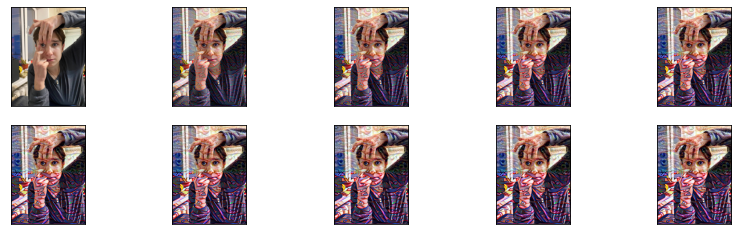

In [ ]:
best, best_loss = run_style_transfer(content_path, style_path_1, style_path_2, num_iterations=1000, content_weight=1e-2, style_weight_1=1e7, style_weight_2=1e7, mixed = False)

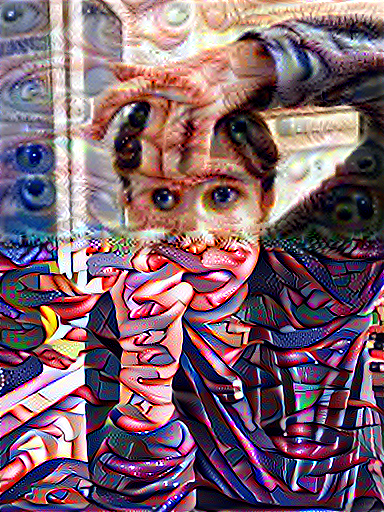

In [ ]:
PIL.Image.fromarray(best)

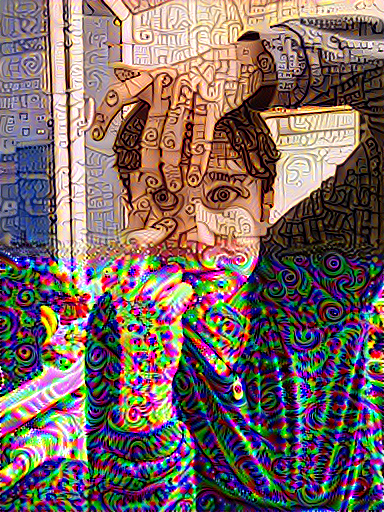

In [ ]:
PIL.Image.fromarray(best)

In [ ]:
from skimage.io import imsave
imsave('C:/Users/Xiaomi/Desktop/Elvira.jpg', best)

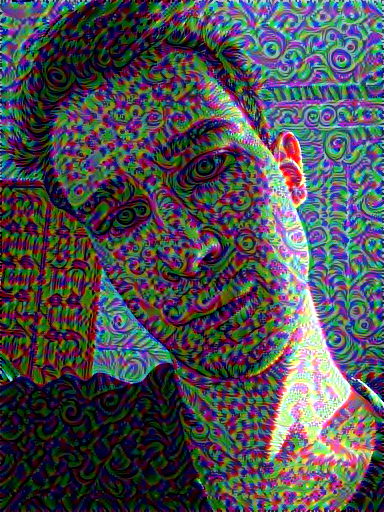

In [ ]:
PIL.Image.fromarray(best)